In [1]:
import random
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import pandas as pd
import math
import seaborn as sns

# Import de la base et création du réseau

In [2]:
df = pd.read_stata('TRADHIST_v4.dta')

In [3]:
#On filtre la période 1962-1975
df["year"] = df["year"].apply(int)
df = df[df['year'].isin(range(1962, 1976))]

#On filtre les lignes qui indiquent bien des pays d'arrivée et de départ
print(["Nombres de lignes", len(df)])
print(["Valeurs manquantes pour pays de départ", sum(df["iso_o"] == "")])
print(["Valeurs manquantes pour pays d'arrivée", sum(df["iso_d"] == "")])

df = df[df["iso_d"] != ""]
df = df[df["iso_o"] != ""]
print(["Nombres de lignes", len(df)])

#On filtre les fluxs pour ne retenir que ceux pour lesquels le flow est renseigné
print(["Valeurs manquantes pour le flux", sum(df["FLOW"].isna())])
df = df[df["FLOW"].isna() == False]
print(["Nombres de lignes", len(df)])

['Nombres de lignes', 400101]
['Valeurs manquantes pour pays de départ', 69]
["Valeurs manquantes pour pays d'arrivée", 69]
['Nombres de lignes', 399963]
['Valeurs manquantes pour le flux', 98760]
['Nombres de lignes', 301203]


#### Système de pondération n°1

In [4]:
#On crée un network par an 
liste_networks = []
for year in tqdm.tqdm(range(1962, 1976)):
    locals()["group"+ str(year)] = df[df["year"] == year]
    locals()["net"+ str(year)] = nx.from_pandas_edgelist(locals()["group"+ str(year)], 'iso_o', 'iso_d', edge_attr= 'FLOW')
    liste_networks.append(locals()["net"+ str(year)])

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:02<00:00,  5.14it/s]


#### Système de pondération n°2

In [6]:
print(df[["FLOW", "GDP_o"]].describe())

#On filtre les fluxs pour ne retenir que ceux pour lesquels le pays d'origine est renseigné
print(["Valeurs manquantes pour le flux", sum(df["GDP_o"].isna())])
df = df[df["GDP_o"].isna() == False]
print(["Nombres de lignes", len(df)])

#Création de la variable de poids n°2
df["weight2"] = df["FLOW"]*100/df["GDP_o"]
df["weight2"].describe()


               FLOW         GDP_o
count  3.012030e+05  2.651870e+05
mean   6.586297e+06  1.191383e+10
std    8.299523e+07  4.835501e+10
min    0.000000e+00  3.258127e+06
25%    0.000000e+00  2.664668e+08
50%    0.000000e+00  1.123454e+09
75%    3.139508e+05  5.334645e+09
max    1.147334e+10  7.634624e+11
['Valeurs manquantes pour le flux', 36016]
['Nombres de lignes', 265187]


count    265187.000000
mean          0.165693
std           1.312350
min           0.000000
25%           0.000000
50%           0.000000
75%           0.015815
max         162.080978
Name: weight2, dtype: float64

In [7]:
#On procède de même que pour la première série de graphes (en utilisant l'option DiGraph() pour créér des réseaux orientés)
liste_networks_oriented = []
for year in tqdm.tqdm(range(1962, 1976)):
    locals()["group"+ str(year)] = df[df["year"] == year]
    locals()["net_oriented"+ str(year)] = nx.from_pandas_edgelist(locals()["group"+ str(year)], 'iso_o', 'iso_d', edge_attr= 'weight2', create_using=nx.DiGraph())
    liste_networks_oriented.append(locals()["net_oriented"+ str(year)])

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:02<00:00,  5.82it/s]


# I - Statistiques descriptives à l'échelle du réseau

## Réseau non orienté 

In [5]:
print([len(G.nodes()) for G in liste_networks])

[180, 180, 180, 180, 180, 181, 181, 181, 181, 181, 181, 181, 181, 181]


On a toujours exactement 181 noeuds dans le réseau, peu importe la période considérée. 

### Mesures non pondérées

### Densité

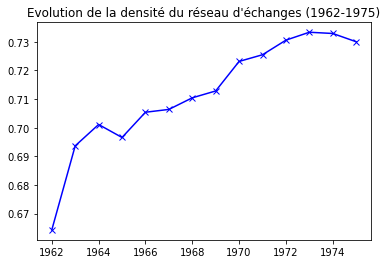

In [6]:
plt.plot(range(1962, 1976), [nx.density(G) for G in liste_networks],  "-xb")
plt.title("Evolution de la densité du réseau d'échanges (1962-1975)")
plt.show()

http://www.cepii.fr/pdf_pub/wp/2013/wp2013-24.pdf
D'après le CEPII (utilisant la base BACI), 


*The trade network is characterized by high dimensionality and strong heterogeneity. The
22002 existing links in 2007 correspond to a density of the network of 0.7 (i.e the ratio between the number of “realized” links and the number of maximum links possible),
indicating that taking two countries at random the probability of an existing trade link
among them is of 70%.*

Même ordre de grandeur ici (https://core.ac.uk/download/pdf/54926841.pdf)


 <span style="color:blue">**Ici, on doit avoir une densité du réseau artificiellement augmentée par le fait qu'on ne considère que 181 pays parmi les 195 ?** </span>

### Diamètre

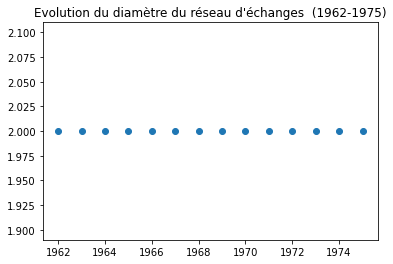

In [7]:
plt.scatter(range(1962, 1976), [nx.diameter(G) for G in liste_networks])
plt.title("Evolution du diamètre du réseau d'échanges  (1962-1975)")
plt.show()

**Résultat toujours vérifié en 2013 pour le réseau des échanges de 2009**: 
    An anatomy of the World Trade Network, William Chow, https://www.hkeconomy.gov.hk/en/pdf/wp/An%20Anatomy%20of%20the%20World%20Trade%20Network%20(July%202013).pdf
    

###  Etude de la distribution du degré

#### Degré moyen

In [68]:
for G in liste_networks:
    print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 180
Number of edges: 10702
Average degree: 118.9111
Name: 
Type: Graph
Number of nodes: 180
Number of edges: 11175
Average degree: 124.1667
Name: 
Type: Graph
Number of nodes: 180
Number of edges: 11295
Average degree: 125.5000
Name: 
Type: Graph
Number of nodes: 180
Number of edges: 11222
Average degree: 124.6889
Name: 
Type: Graph
Number of nodes: 180
Number of edges: 11364
Average degree: 126.2667
Name: 
Type: Graph
Number of nodes: 181
Number of edges: 11507
Average degree: 127.1492
Name: 
Type: Graph
Number of nodes: 181
Number of edges: 11573
Average degree: 127.8785
Name: 
Type: Graph
Number of nodes: 181
Number of edges: 11612
Average degree: 128.3094
Name: 
Type: Graph
Number of nodes: 181
Number of edges: 11780
Average degree: 130.1657
Name: 
Type: Graph
Number of nodes: 181
Number of edges: 11818
Average degree: 130.5856
Name: 
Type: Graph
Number of nodes: 181
Number of edges: 11901
Average degree: 131.5028
Name: 
Type: Graph
Number of nod

Le degré moyen et le nombre de liens semble augmenter au cours de la période. 

#### Histogramme du degré

In [151]:
#Fonction utilisée précédemment dans les TD pour la représentation en loglog de la distribution du degré. 
def logBinning(degreeList,nbin):
    kmin=min(degreeList)
    kmax=max(degreeList)
    logBins = np.logspace(np.log10(kmin), np.log10(kmax),num=nbin)
    logBinDensity, binedges = np.histogram(degreeList, bins=logBins, density=True)
    logBins = np.delete(logBins, -1)

    return logBinDensity, logBins

0


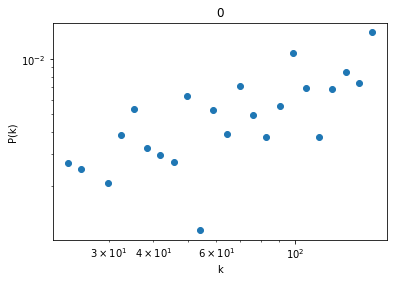

1


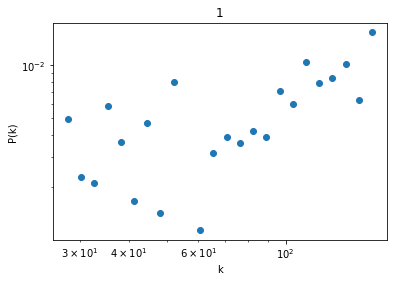

2


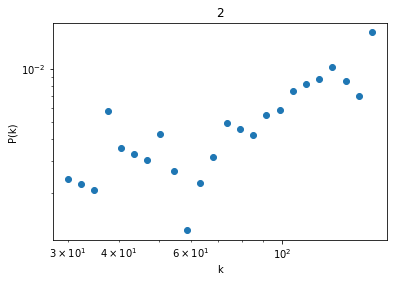

3


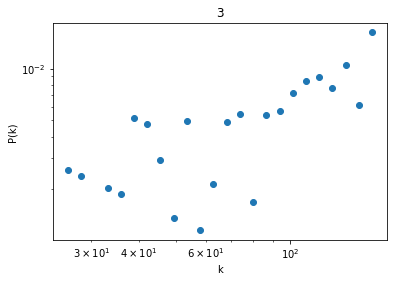

4


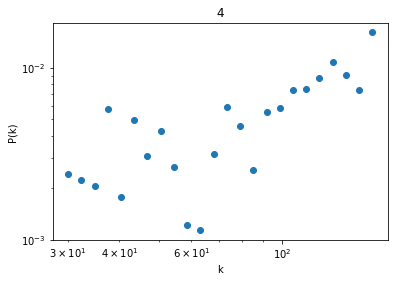

5


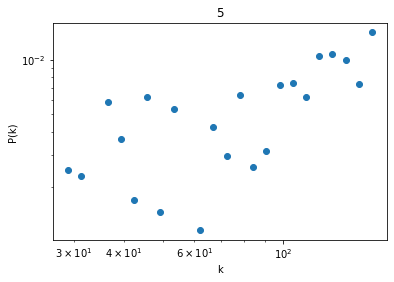

6


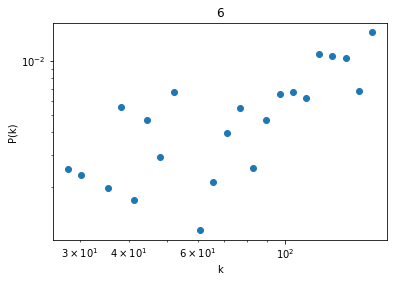

7


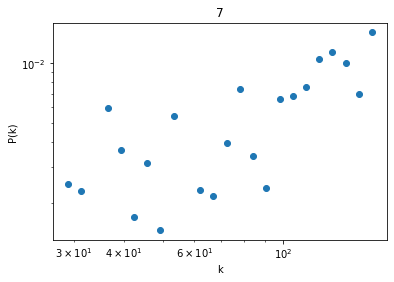

8


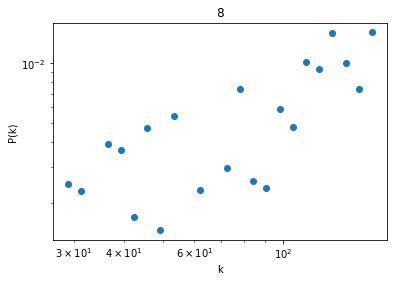

9


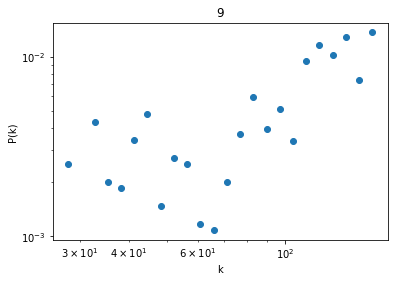

10


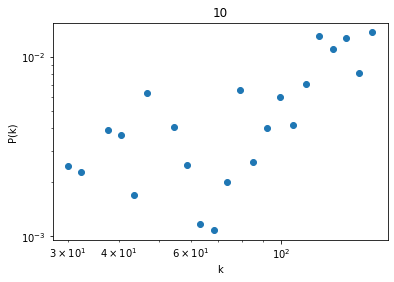

11


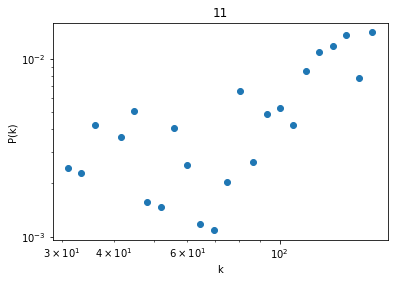

12


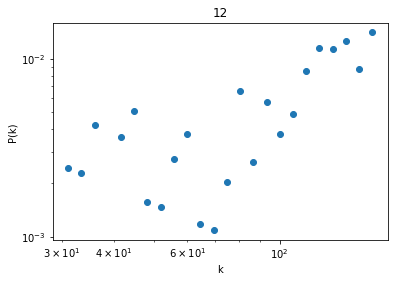

13


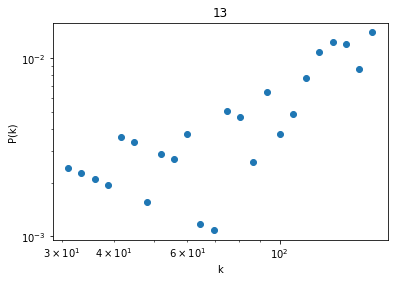

In [144]:
liste_kappa = []
for j in range(len(liste_networks)):
    print(j)
    xx=[ liste_networks[j].degree(i) for i in list(liste_networks[j].nodes())]
    y,x=logBinning(np.array(xx),25)
    plt.loglog(x,y,'o')
    plt.title(str(j))
    plt.xlabel('k')
    plt.ylabel('P(k)')
    liste_kappa.append(np.mean([u**2 for u in xx])/(np.mean(xx))**2)
    plt.show()

 <span style="color:blue">**Je comprends pas pourquoi ils ont cette distribution, c'est aucun des cas évoqués dans le cours, et c'est pas non plus la distribution obtenue dans la littérature. J'ai l'impression que c'est parce que globalement tout le monde a le même degré.**</span>

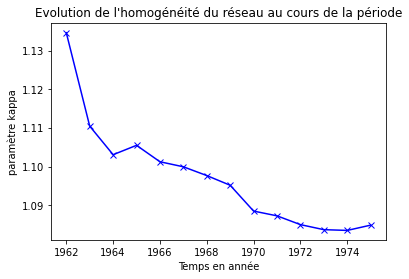

In [150]:
plt.title("Evolution de l'homogénéité du réseau au cours de la période")
plt.plot(range(1962,1976), liste_kappa, "-xb")
plt.xlabel('Temps en année')
plt.ylabel('paramètre kappa')
plt.show()

On constate que pour toute période, l'indicateur d'hétérogénéité $\kappa$ est supérieur à 1, et de l'ordre de 1,1. Ce résultat implique que le réseau est homogène, et qu'il y a peu de variations autour du degré moyen (entre 120 et 130 selon la période). 

### Mesures faisant intervenir la pondération [Analyse différenciée selon les deux réseaux]

### Coefficient de clustering moyen

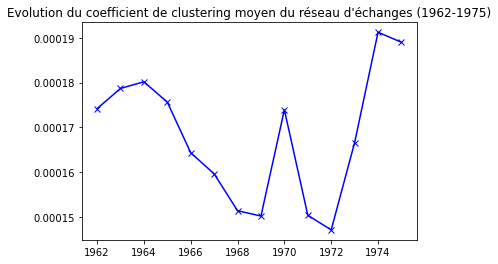

In [8]:
#Réseau orienté
plt.plot(range(1962, 1976), [nx.average_clustering(G, weight= "FLOW") for G in liste_networks],  "-xb")
plt.title("Evolution du coefficient de clustering moyen du réseau d'échanges non orienté (1962-1975)")
plt.show()

100%|█████████████████████████████████████████████████████████████████████████████████| 14/14 [30:19<00:00, 129.97s/it]


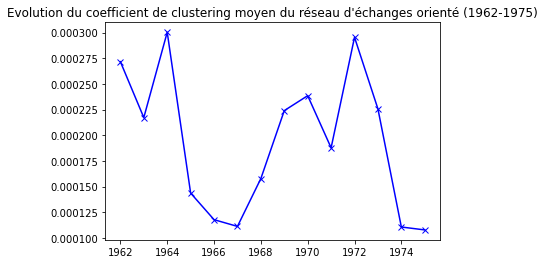

In [8]:
#Ne pas faire tourner car met trop de temps [image enregistrée]
plt.plot(range(1962, 1976), [nx.average_clustering(G, weight= "weight2") for G in tqdm.tqdm(liste_networks_oriented)],  "-xb")
plt.title("Evolution du coefficient de clustering moyen du réseau d'échanges orienté (1962-1975)")
plt.show()

### Average shortest path

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:14<00:00,  5.35s/it]


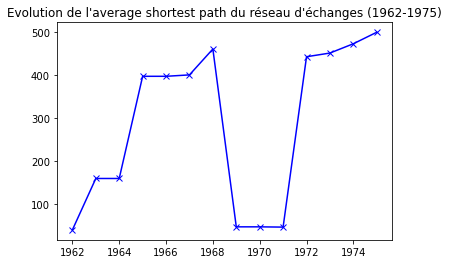

In [9]:
plt.plot(range(1962, 1976), [nx.average_shortest_path_length(G, weight= "FLOW") for G in tqdm.tqdm(liste_networks)], "-xb")
plt.title("Evolution de l'average shortest path du réseau d'échanges non orienté (1962-1975)")
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:42<00:00,  3.05s/it]


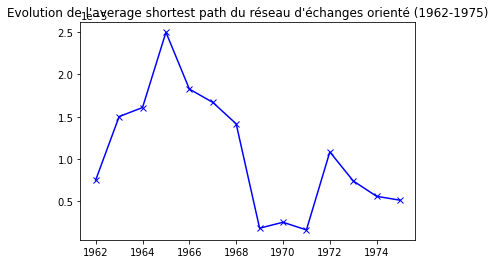

In [10]:
#Ne pas faire tourner car met trop de temps [image enregistrée]
plt.plot(range(1962, 1976), [nx.average_shortest_path_length(G, weight= "weight2") for G in tqdm.tqdm(liste_networks_oriented)],  "-xb")
plt.title("Evolution de l'average shortest path du réseau d'échanges orienté (1962-1975)")
plt.show()

An anatomy of the World Trade Network, William Chow (https://www.hkeconomy.gov.hk/en/pdf/wp/An%20Anatomy%20of%20the%20World%20Trade%20Network%20(July%202013).pdf) reporte un average shortest path de 1.38 pour le réseau de 2009.


## Mesures de centralité dans le réseau

On cherche ici à observer les points les plus centraux et les moins centraux des réseau, en passant en revue les différentes mesures de centralité. 

In [75]:
i = 1962
for G in liste_networks :
    print(str(i))
    #Degree centrality
    dict_ = nx.degree_centrality(G)
    max_keys = [key for key, value in dict_.items() if value == max(dict_.values())]
    print(['Max degree centrality',max_keys])
    min_keys = [key for key, value in dict_.items() if value == min(dict_.values())]
    print(['Min degree centrality',min_keys])
    
    #Closeness centrality
    dict_ = nx.closeness_centrality(G)
    max_keys = [key for key, value in dict_.items() if value == max(dict_.values())]
    print(['Max closeness centrality',max_keys])
    min_keys = [key for key, value in dict_.items() if value == min(dict_.values())]
    print(['Min closeness centrality',min_keys])
    
    #Betweeness centrality
    dict_ = nx.betweenness_centrality(G)
    max_keys = [key for key, value in dict_.items() if value == max(dict_.values())]
    print(['Max betweenness centrality',max_keys])
    min_keys = [key for key, value in dict_.items() if value == min(dict_.values())]
    print(['Min betweenness centrality',min_keys])
    
    #Eigenvector centrality
    dict_ = nx.eigenvector_centrality(G)
    max_keys = [key for key, value in dict_.items() if value == max(dict_.values())]
    print(['Max eigenvector centrality',max_keys])
    min_keys = [key for key, value in dict_.items() if value == min(dict_.values())]
    print(['Min eigenvector centrality',min_keys])
    
    

    i = i + 1

1962
['Max degree centrality', ['CHE', 'GBR']]
['Min degree centrality', ['TWN']]
['Max closeness centrality', ['CHE', 'GBR']]
['Min closeness centrality', ['TWN']]
['Max betweenness centrality', ['CHE', 'GBR']]
['Min betweenness centrality', ['SHN', 'TUV']]
['Max eigenvector centrality', ['CHE', 'GBR']]
['Min eigenvector centrality', ['TWN']]
1963
['Max degree centrality', ['CHE', 'DNK', 'GBR', 'IND']]
['Min degree centrality', ['SHN']]
['Max closeness centrality', ['CHE', 'DNK', 'GBR', 'IND']]
['Min closeness centrality', ['SHN']]
['Max betweenness centrality', ['CHE', 'DNK', 'GBR', 'IND']]
['Min betweenness centrality', ['SHN', 'KNA', 'TUV']]
['Max eigenvector centrality', ['CHE', 'DNK', 'GBR', 'IND']]
['Min eigenvector centrality', ['SHN']]
1964
['Max degree centrality', ['CHE']]
['Min degree centrality', ['SHN']]
['Max closeness centrality', ['CHE']]
['Min closeness centrality', ['SHN']]
['Max betweenness centrality', ['CHE']]
['Min betweenness centrality', ['SHN', 'TUV']]
['Max e

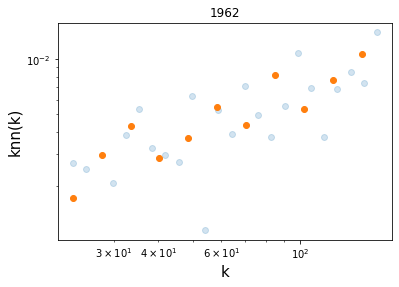

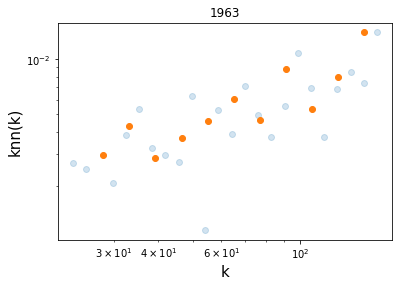

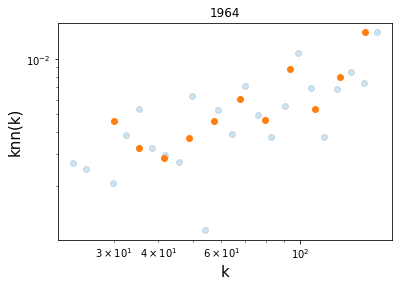

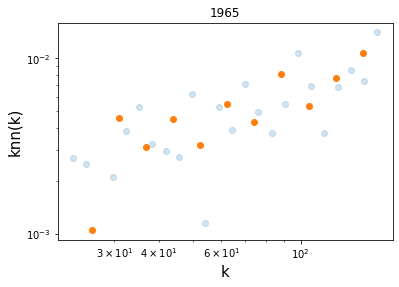

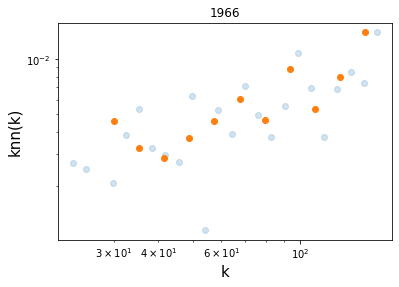

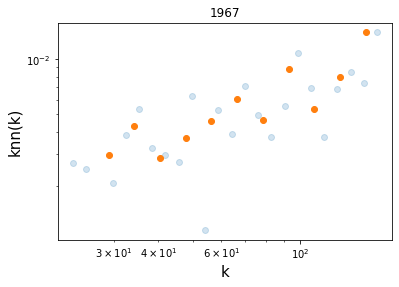

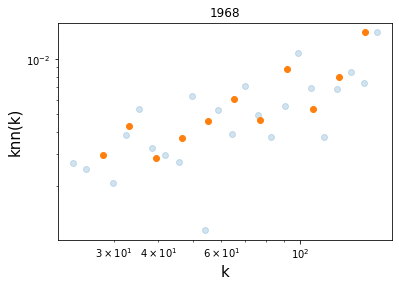

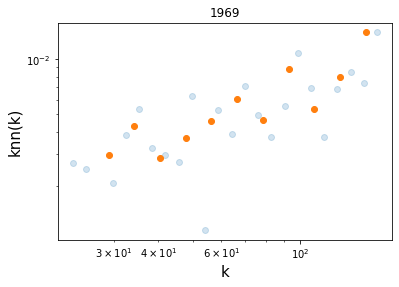

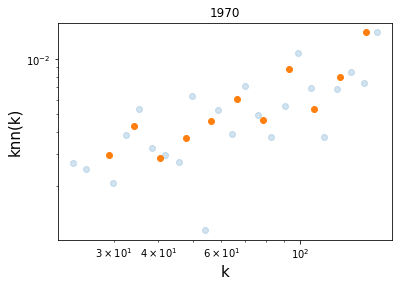

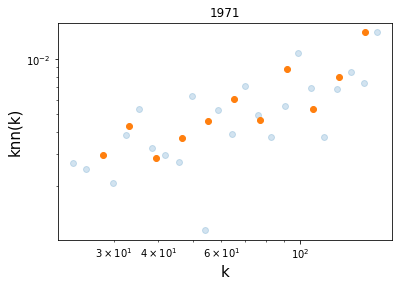

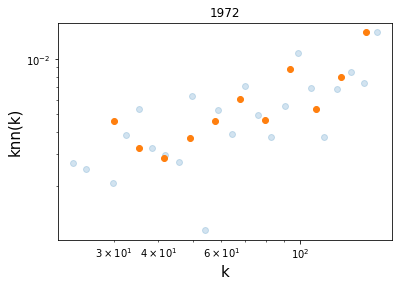

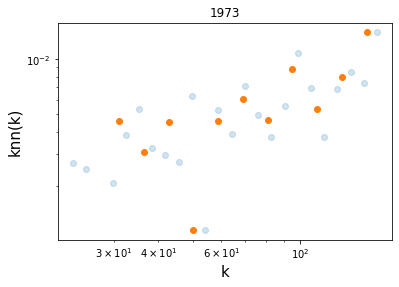

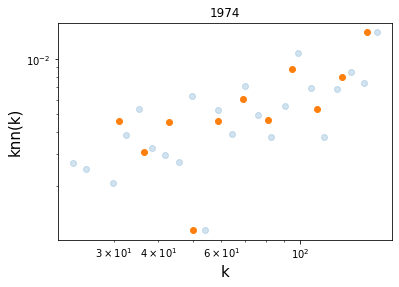

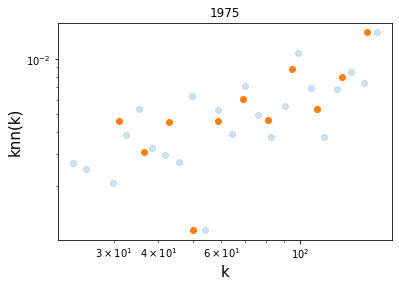

In [87]:
import scipy.stats

def knn(k):
        liste = list(degree_df[degree_df[1] == k][0])
        L = []
        for noeud in liste:
            L.append(knn_i(noeud))
        return(np.mean(L))

i = 1962
for G in liste_networks: 
    degree_df = pd.DataFrame(G.degree())
    kmin=min(degree_df[1])
    kmax=max(degree_df[1])
    logBins = np.logspace(np.log10(kmin), np.log10(kmax), num = 12)

    plt.loglog(x,y,'o',alpha=0.2)
    ybin,xbin,binnumber=scipy.stats.binned_statistic(x,y,statistic='mean',bins=logBins)
    plt.loglog(xbin[:-1],ybin,'o')
    plt.title(str(i))
    plt.xlabel('k',size=15)
    plt.ylabel('knn(k)',size=15)
    plt.show()
    
    i = i + 1

Pour l'ensemble des réseaux, on remarque une tendance croissante du graphe. présenter un comportement d'$assortative$  $mixing$, ou $degree$  $homophily$, ce qui signifie que les noeuds présentant les plus hauts degrées ont tendance à être connectés à d'autres noeuds de haut degrée. Cette tendance n'est cependant pas très marquée, on constate que le nuage de points ne forme pas de ligne claire. 

# II - Statistiques descriptives à l'échelles des noeuds

On se concentre sur un sous-ensemble de noeuds, et on cherche à évaluer l'évolution de leur position dans le réseau au cours de la période.

 <span style="color:blue">**Antoine je te laisse compléter la liste des pays qui t'intéressent pour ton mémoire.** </span>

In [113]:
liste_pays = ["FRA", "DZA", "CMR"]

FRA
DZA
CMR


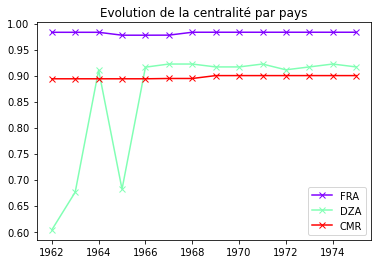

""


In [114]:
color = plt.cm.rainbow(np.linspace(0, 1, len(liste_pays)))

for i in range(0,len(liste_pays)):
    pays = liste_pays[i]
    col = color[i]
    print(pays)
    plt.plot(range(1962, 1976),[nx.degree_centrality(G)[pays] for G in tqdm.tqdm(liste_networks)] , "-xb", c = col, label = pays)
    plt.title("Evolution de la centralité par pays")
plt.legend()
plt.show()

FRA
DZA
CMR


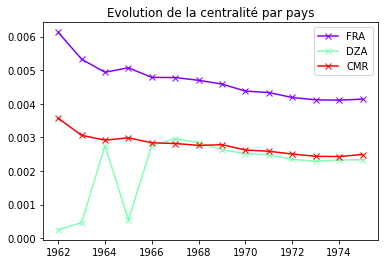

""


In [115]:
color = plt.cm.rainbow(np.linspace(0, 1, len(liste_pays)))


for i in range(0,len(liste_pays)):
    pays = liste_pays[i]
    col = color[i]
    print(pays)
    plt.plot(range(1962, 1976),[nx.betweenness_centrality(G)[pays] for G in tqdm.tqdm(liste_networks)] , "-xb", c = col, label = pays)
    plt.title("Evolution de la centralité between par pays")
plt.legend()
plt.show()


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

FRA


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

DZA


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

CMR


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:14<00:00,  1.02s/it]


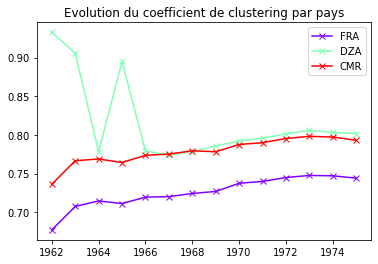

""


In [118]:
color = plt.cm.rainbow(np.linspace(0, 1, len(liste_pays)))


for i in range(0,len(liste_pays)):
    pays = liste_pays[i]
    col = color[i]
    print(pays)
    plt.plot(range(1962, 1976),[nx.clustering(G)[pays] for G in tqdm.tqdm(liste_networks)] , "-xb", c = col, label = pays)
    plt.title("Evolution du coefficient de clustering par pays")
plt.legend()
plt.show()


# III - Etude des communautés à l'intérieur du réseau

## Etude des cliques

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:12<00:00,  5.17s/it]


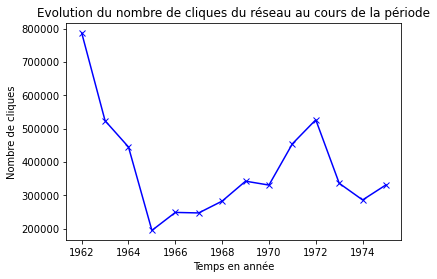

In [157]:
#Ne pas faire tourner (met un peu longtemps)
#Rappel : on cherche le nombre de cliques sur un graphe non orienté

plt.title("Evolution du nombre de cliques du réseau au cours de la période")
plt.plot(range(1962,1976),  [len(list(nx.find_cliques(G))) for G in tqdm.tqdm(liste_networks)], "-xb")
plt.xlabel('Temps en année')
plt.ylabel('Nombre de cliques')
plt.show()

On cherche à observer 

  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

FRA


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

DZA


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

CMR


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:37<00:00,  2.68s/it]


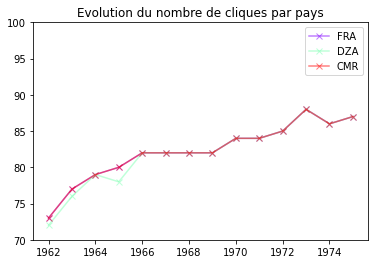

""


In [173]:
color = plt.cm.rainbow(np.linspace(0, 1, len(liste_pays)))

for i in range(0,len(liste_pays)):
    pays = liste_pays[i]
    col = color[i]
    print(pays)
    plt.plot(range(1962, 1976),[nx.node_clique_number(G, nodes= pays) for G in tqdm.tqdm(liste_networks)] , "-xb", c = col, alpha = 0.5, label = pays)
    plt.title("Evolution du nombre de cliques par pays")
    plt.ylim([70, 100])
plt.legend()
plt.show()
pays_centrality

<span style="color:blue">**Les courbes du nombre de cliques par pays du Cameroun et de la France sont complètements confondues => pas sûre qu'il s'agisse d'une statistique intéressante à regarder.**</span>

### Homophilie basée sur les réseaux existants

<span style="color:blue">**Il faut qu'on importe les trucs qu'on veut regarder comme des variables catégorielles au dataframe df, à savoir dans mon souvenir**</span>
    
    - AEF
    - AOF 
    - franc CFA

Ensuite on doit simplement : 
    - convertir df[["iso_o","groupe1", "groupe2", "groupe3"]] en dictionnaires
    
    - Pour chaque network G, utiliser la commande nx.set_node_attributes(G, dictionnaire, "groupe")
    
    - Pour chaque groupe, nx. attribute_assortativity_coefficient (G, category)